Proyecto 1 – Ingeniería de Datos + Análisis de Datos

Setup

In [ ]:
# === Librerías ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import dedent
from IPython.display import display

# === Configuración visual y pandas ===
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 180)
pd.options.mode.chained_assignment = None 

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# === Reproducibilidad ===
SEED = 42
np.random.seed(SEED)

# === Utilidades ===
def print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

def percent(x):
    try:
        return f"{100*float(x):.2f}%"
    except:
        return "NA"


Tarea 3: Preparación de los datos

Carga de datos y verificación

In [ ]:
print_section ("1) Carga de datos e inspección")
DATA_PATH = "incident_event_log.csv"  

df_raw = pd.read_csv(DATA_PATH, low_memory=False)
print("Shape:", df_raw.shape)
display(df_raw.head(3))
df_raw.info()


1) Carga de datos e inspección
Shape: (141712, 36)


,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

Normalización de nombres y verificación de columnas




In [ ]:
print_section("2) Normalización de nombres y verificación de columnas")
df = df_raw.copy()
df.columns = df.columns.str.strip()


if "closed_code" in df.columns and "close_code" not in df.columns:
    df.rename(columns={"closed_code": "close_code"}, inplace=True)

expected_date_cols = ["opened_at","resolved_at","closed_at","sys_created_at","sys_updated_at"]
existing_date_cols = [c for c in expected_date_cols if c in df.columns]
missing_date_cols = [c for c in expected_date_cols if c not in df.columns]

print("Fechas presentes:", existing_date_cols)
if missing_date_cols:
    print("ATENCIÓN - Faltan columnas de fecha:", missing_date_cols)

if "number" not in df.columns:
    raise ValueError("No se encuentra 'number' (identificador del incidente).")



2) Normalización de nombres y verificación de columnas
Fechas presentes: ['opened_at', 'resolved_at', 'closed_at', 'sys_created_at', 'sys_updated_at']


Conversión a datetime (UTC, tolerante a errores)

In [15]:
print_section("3) Conversión a datetime (UTC)")
for col in existing_date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce", utc=True, dayfirst=True)

display(df[existing_date_cols].head(3))



3) Conversión a datetime (UTC)


,opened_at,resolved_at,closed_at,sys_created_at,sys_updated_at
0,2016-02-29 01:16:00+00:00,2016-02-29 11:29:00+00:00,2016-03-05 12:00:00+00:00,2016-02-29 01:23:00+00:00,2016-02-29 01:23:00+00:00
1,2016-02-29 01:16:00+00:00,2016-02-29 11:29:00+00:00,2016-03-05 12:00:00+00:00,2016-02-29 01:23:00+00:00,2016-02-29 08:53:00+00:00
2,2016-02-29 01:16:00+00:00,2016-02-29 11:29:00+00:00,2016-03-05 12:00:00+00:00,2016-02-29 01:23:00+00:00,2016-02-29 11:29:00+00:00


Consolidación a 1 fila por incidente

In [ ]:
print_section("4) Consolidación a 1 fila por incidente")

use_alternative_B = False  

if not use_alternative_B:
    # (A) Último estado por incidente
    sort_cols = []
    if "sys_updated_at" in df.columns: sort_cols.append("sys_updated_at")
    if "sys_mod_count" in df.columns:  sort_cols.append("sys_mod_count")
    if not sort_cols and "sys_created_at" in df.columns:
        sort_cols = ["sys_created_at"]
    if not sort_cols:
        raise ValueError("No hay columnas temporales para ordenar snapshots.")

    df_sorted = df.sort_values(by=["number"] + sort_cols)
    df_inc = df_sorted.groupby("number", as_index=False).tail(1).copy()
else:
    # (B) Última versión con resolved_at no nulo
    if "resolved_at" not in df.columns:
        raise ValueError("Falta 'resolved_at' para la alternativa B.")
    df_nonnull = df[df["resolved_at"].notna()].copy()
    if df_nonnull.empty:
        raise ValueError("No hay filas con 'resolved_at' no nulo.")
    sort_cols = []
    if "sys_updated_at" in df_nonnull.columns: sort_cols.append("sys_updated_at")
    if "sys_mod_count" in df_nonnull.columns:  sort_cols.append("sys_mod_count")
    if not sort_cols and "sys_created_at" in df_nonnull.columns:
        sort_cols = ["sys_created_at"]
    df_sorted = df_nonnull.sort_values(by=["number"] + sort_cols)
    df_inc = df_sorted.groupby("number", as_index=False).tail(1).copy()

print("Original:", df.shape, "→ Consolidado:", df_inc.shape)
print("Duplicados por 'number' post-consolidación:", df_inc.duplicated(subset=['number']).sum())
display(df_inc.head(3))



4) Consolidación a 1 fila por incidente
Original: (141712, 36) → Consolidado: (24918, 36)
Duplicados por 'number' post-consolidación: 0


,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,close_code,resolved_by,resolved_at,closed_at
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00+00:00,Created by 6,2016-02-29 01:23:00+00:00,Updated by 908,2016-03-05 12:00:00+00:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00+00:00,2016-03-05 12:00:00+00:00
12,INC0000047,Closed,False,1,0,8,True,Caller 2403,Opened by 397,2016-02-29 04:40:00+00:00,Created by 171,2016-02-29 04:57:00+00:00,Updated by 908,2016-03-06 10:00:00+00:00,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 24,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00+00:00,2016-03-06 10:00:00+00:00
19,INC0000057,Closed,False,0,0,6,True,Caller 4416,Opened by 8,2016-02-29 06:10:00+00:00,?,NaT,Updated by 908,2016-03-06 03:00:00+00:00,Phone,Location 204,Category 20,Subcategory 125,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 6,True,False,Do Not Notify,Problem ID 2,?,?,?,code 10,Resolved by 5,2016-03-01 02:55:00+00:00,2016-03-06 03:00:00+00:00


Objetivo ttr_h (horas).

In [ ]:
print_section("5) Cálculo de 'ttr_h' (horas)")

if "opened_at" not in df_inc.columns or "resolved_at" not in df_inc.columns:
    raise ValueError("Se requieren 'opened_at' y 'resolved_at'.")

df_inc["ttr_h"] = (df_inc["resolved_at"] - df_inc["opened_at"]).dt.total_seconds() / 3600

negatives = df_inc["ttr_h"].lt(0).sum()
total_non_null = df_inc["ttr_h"].notna().sum()
print(f"Duraciones negativas a eliminar: {negatives} de {total_non_null} ({percent(negatives/max(total_non_null,1))})")

# Eliminar SOLO los tiempos negativos, que no tendrían sentido
df_inc = df_inc[(df_inc["ttr_h"].isna()) | (df_inc["ttr_h"] >= 0)].copy()
display(df_inc["ttr_h"].describe(percentiles=[.01,.05,.5,.95,.99]))



5) Cálculo de 'ttr_h' (horas)
Duraciones negativas a eliminar: 0 de 23362 (0.00%)


count    23362.000000
mean       178.171582
std        532.787772
min          0.000000
1%           0.016667
5%           0.050000
50%         22.100000
95%        710.517500
99%       2843.400667
max       8070.166667
Name: ttr_h, dtype: float64

Helpers y mapeo de niveles

In [ ]:
print_section("6) Helpers y mapeo de niveles")

def parse_level(val):
    """
    Convierte '1 - High', '2-Medium', '3 Low' (u otras variantes) a enteros 1/2/3.
    Si ya es numérico y válido, lo regresa; si no, NaN.
    """
    if pd.isna(val): return np.nan
  
    if isinstance(val, (int, float)) and str(int(val)) in {"1","2","3"}:
        vi = int(val)
        return vi if vi in (1,2,3) else np.nan
    s = str(val).strip().lower()
    for k in ["1","2","3"]:
        if s.startswith(k):
            return int(k)
    mapping_words = {"high":1, "alto":1, "medium":2, "medio":2, "low":3, "bajo":3}
    for w, code in mapping_words.items():
        if w in s:
            return code
    return np.nan

def reduc_mayus(x, n=3):
    """
    Helper de texto estilo taller: primeros n chars a MAYÚSCULAS (para etiquetas compactas).
    """
    if pd.isna(x): return x
    s = str(x).strip()
    return s[:n].upper()

for col in ["impact","urgency","priority"]:
    if col in df_inc.columns:
        df_inc[f"{col}_level"] = df_inc[col].map(parse_level)

if "category" in df_inc.columns:
    df_inc["category_tag"] = df_inc["category"].map(lambda z: reduc_mayus(z, 3))

display(df_inc[[c for c in df_inc.columns if c.endswith("_level")]].head())



6) Helpers y mapeo de niveles


,impact_level,urgency_level,priority_level
3,2,2,3
12,2,2,3
19,2,2,3
23,2,2,3
31,1,2,2


Outliers del objetivo

In [19]:
print_section("7) Outliers: flag + transformaciones para EDA")

mask_valid = df_inc["ttr_h"].notna()
p1, p99 = df_inc.loc[mask_valid, "ttr_h"].quantile([0.01, 0.99])
print(f"p1={p1:.3f} h, p99={p99:.3f} h")

df_inc["ttr_outlier"]  = np.where(df_inc["ttr_h"].notna() & ((df_inc["ttr_h"] < p1) | (df_inc["ttr_h"] > p99)), 1, 0)
df_inc["ttr_h_winsor"] = df_inc["ttr_h"].clip(lower=p1, upper=p99)
df_inc["ttr_h_log"]    = np.log1p(df_inc["ttr_h"].clip(lower=0))

display(df_inc[["ttr_h","ttr_outlier","ttr_h_winsor","ttr_h_log"]].head())



7) Outliers: flag + transformaciones para EDA
p1=0.017 h, p99=2843.401 h


,ttr_h,ttr_outlier,ttr_h_winsor,ttr_h_log
3,10.216667,0,10.216667,2.417401
12,29.200000,0,29.200000,3.407842
19,20.750000,0,20.750000,3.079614
23,53.466667,0,53.466667,3.997589
31,8.883333,0,8.883333,2.290850


Control de calidad (nulos, duplicados, distribuciones)

In [20]:
print_section("8) Control de calidad: nulos y duplicados")

# Nulos (top 30)
nulls = df_inc.isna().mean().sort_values(ascending=False).head(30).to_frame("pct_nulls")
display(nulls.style.format({"pct_nulls": percent}))

# Duplicados por 'number' después de consolidar
dup_count = df_inc.duplicated(subset=['number']).sum()
print("Duplicados por 'number' (post-consolidación):", dup_count)

# value_counts de categóricas clave (top 10)
for col in ["contact_type","category","subcategory","priority","priority_level"]:
    if col in df_inc.columns:
        print(f"\nDistribución de {col} (top 10):")
        display(df_inc[col].value_counts(dropna=False).head(10).to_frame("conteo"))



8) Control de calidad: nulos y duplicados


,pct_nulls
sys_created_at,46.13%
ttr_h,6.24%
resolved_at,6.24%
ttr_h_log,6.24%
ttr_h_winsor,6.24%
category_tag,0.00%
caused_by,0.00%
knowledge,0.00%
u_priority_confirmation,0.00%
notify,0.00%


Duplicados por 'number' (post-consolidación): 0

Distribución de contact_type (top 10):


,conteo
contact_type,
Phone,24688
Self service,158
Email,59
IVR,9
Direct opening,4



Distribución de category (top 10):


,conteo
category,
Category 42,3558
Category 26,3338
Category 53,2678
Category 46,2432
Category 32,1522
Category 9,1155
Category 37,1144
Category 23,1063
Category 20,1047



Distribución de subcategory (top 10):


,conteo
subcategory,
Subcategory 174,6528
Subcategory 223,3621
Subcategory 175,1896
Subcategory 164,1256
Subcategory 9,888
Subcategory 275,586
Subcategory 135,580
Subcategory 170,508
Subcategory 36,446



Distribución de priority (top 10):


,conteo
priority,
3 - Moderate,23466
4 - Low,774
2 - High,408
1 - Critical,270



Distribución de priority_level (top 10):


,conteo
priority_level,
3,24240
2,408
1,270



8) Distribuciones del objetivo: crudo vs winsor vs log


,count,mean,std,min,1%,5%,50%,95%,99%,max
ttr_h_raw,23362.0,178.171582,532.787772,0.000000,0.016667,0.05,22.1,710.5175,2843.400667,8070.166667
ttr_h_winsor,23362.0,162.542059,403.072071,0.016667,0.016667,0.05,22.1,710.5175,2840.085927,2843.400667


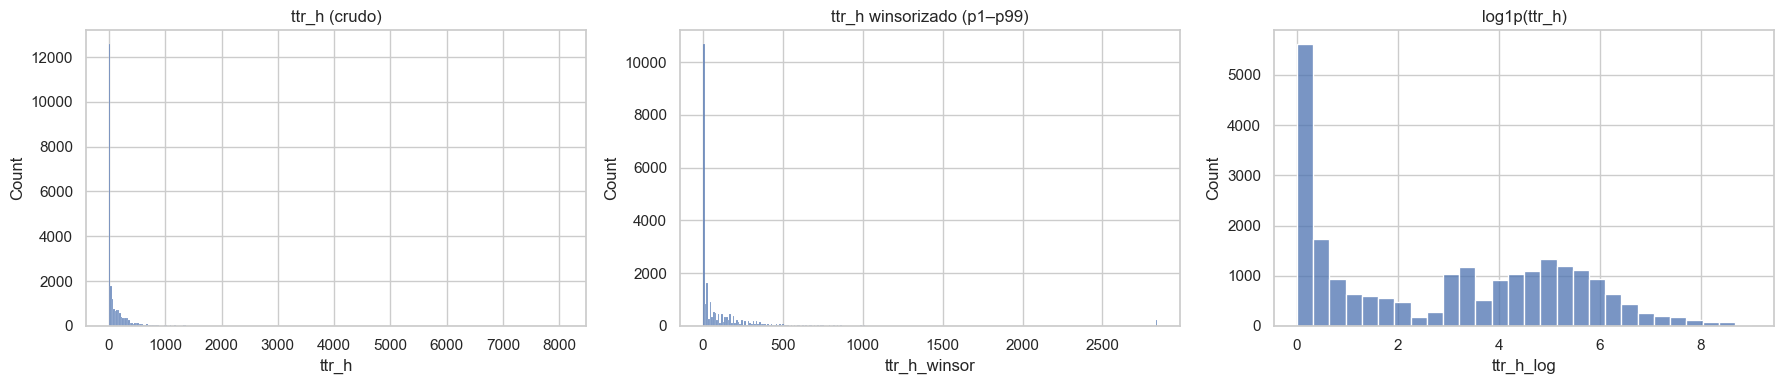

In [21]:
print_section("8) Distribuciones del objetivo: crudo vs winsor vs log")

summary = pd.DataFrame({
    "ttr_h_raw": df_inc["ttr_h"].describe(percentiles=[.01,.05,.5,.95,.99]),
    "ttr_h_winsor": df_inc["ttr_h_winsor"].describe(percentiles=[.01,.05,.5,.95,.99]),
}).T
display(summary)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df_inc["ttr_h"].dropna(), kde=False, ax=axes[0]); axes[0].set_title("ttr_h (crudo)")
sns.histplot(df_inc["ttr_h_winsor"].dropna(), kde=False, ax=axes[1]); axes[1].set_title("ttr_h winsorizado (p1–p99)")
sns.histplot(df_inc["ttr_h_log"].dropna(), kde=False, ax=axes[2]); axes[2].set_title("log1p(ttr_h)")
plt.tight_layout(); plt.show()


Tarea 2: Exploración de datos

EDA (box/violin/scatter), binning y patrones temporales

In [22]:
print_section("9.1) Binning de ttr_h (EDA)")

if "ttr_h" in df_inc.columns:
    # Cortes equidistantes (ejemplo)
    bins_eq = [0, 4, 8, 24, 48, 96, df_inc["ttr_h"].max()]
    df_inc["ttr_bin_eq"] = pd.cut(df_inc["ttr_h"].clip(lower=0), bins=bins_eq, include_lowest=True)

    # Cortes por cuantiles
    try:
        df_inc["ttr_bin_q"] = pd.qcut(df_inc["ttr_h"].clip(lower=0), q=[0, .2, .5, .7, .9, 1], duplicates='drop')
    except ValueError:
        df_inc["ttr_bin_q"] = np.nan

    print("ttr_bin_eq (equidistantes):")
    display(df_inc["ttr_bin_eq"].value_counts(dropna=False).to_frame("conteo"))

    print("\nttr_bin_q (cuantiles):")
    display(df_inc["ttr_bin_q"].value_counts(dropna=False).to_frame("conteo"))

    # Dummies de ejemplo (no para exportar aún)
    ttr_bin_dummies = pd.get_dummies(df_inc["ttr_bin_eq"], dtype=int, prefix="ttr_bin")
    display(ttr_bin_dummies.head())



9.1) Binning de ttr_h (EDA)
ttr_bin_eq (equidistantes):


,conteo
ttr_bin_eq,
"(-0.001, 4.0]",9506
"(96.0, 8070.167]",7407
"(48.0, 96.0]",2049
"(24.0, 48.0]",1834
"(8.0, 24.0]",1590
NaN,1556
"(4.0, 8.0]",976



ttr_bin_q (cuantiles):


,conteo
ttr_bin_q,
"(0.25, 22.1]",6998
"(-0.001, 0.25]",4686
"(113.128, 381.548]",4672
"(22.1, 113.128]",4669
"(381.548, 8070.167]",2337
NaN,1556


,"ttr_bin_(-0.001, 4.0]","ttr_bin_(4.0, 8.0]","ttr_bin_(8.0, 24.0]","ttr_bin_(24.0, 48.0]","ttr_bin_(48.0, 96.0]","ttr_bin_(96.0, 8070.167]"
3,0,0,1,0,0,0
12,0,0,0,1,0,0
19,0,0,1,0,0,0
23,0,0,0,0,1,0
31,0,0,1,0,0,0



9.2) Boxplots por niveles/categorías


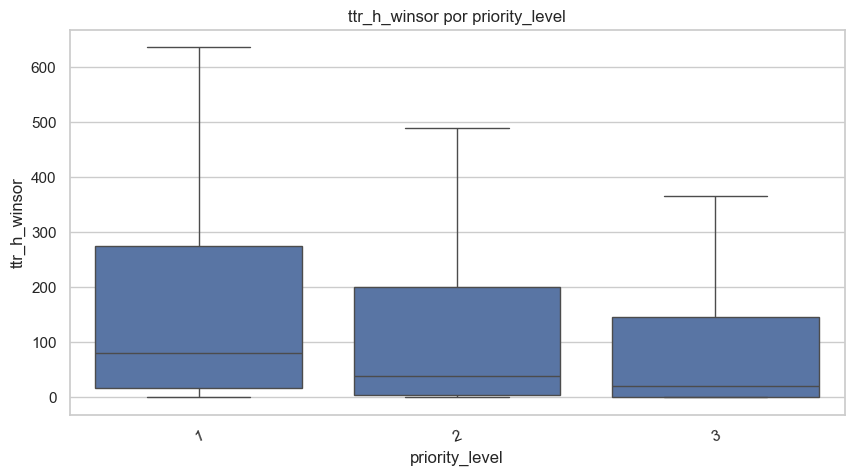

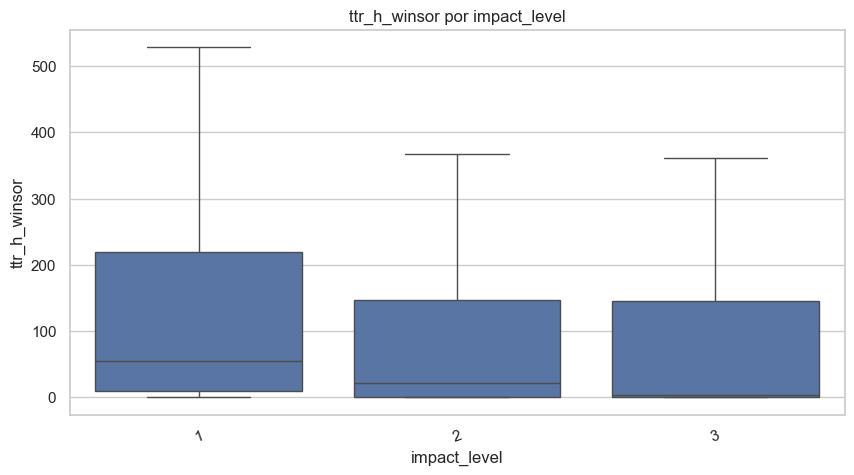

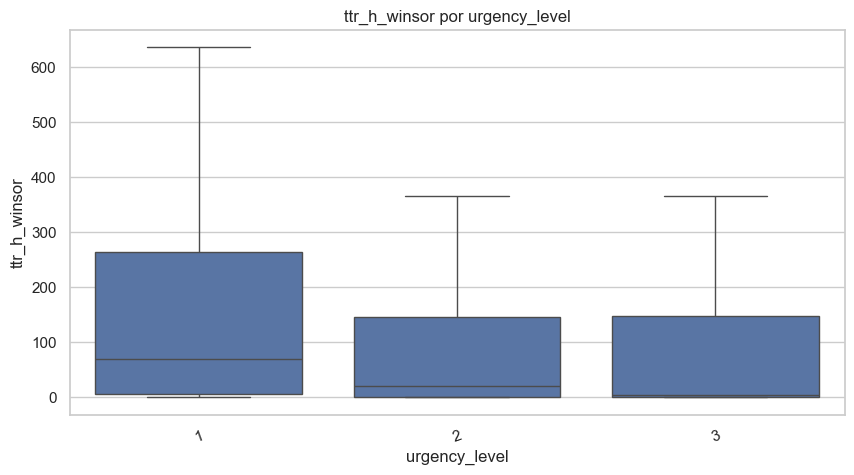

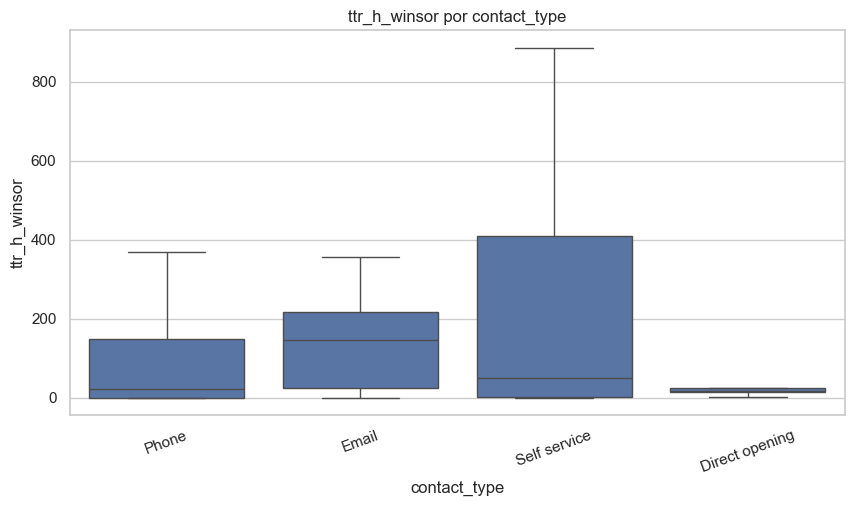

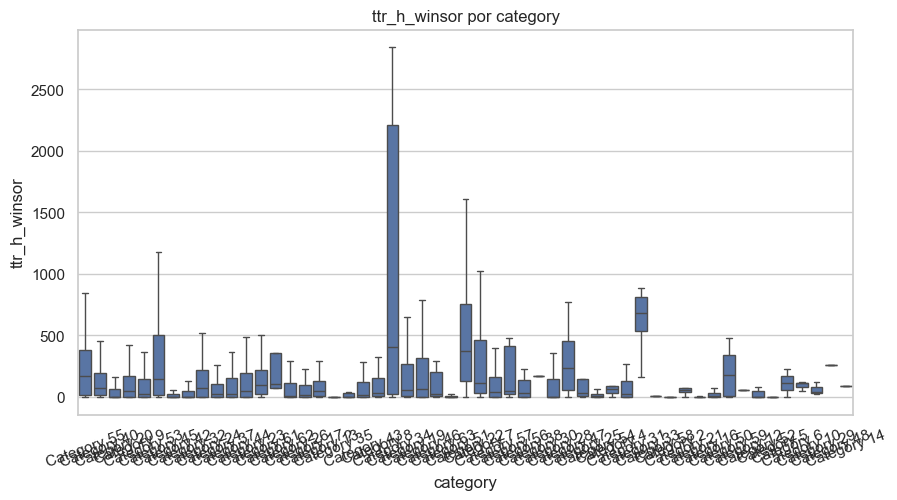

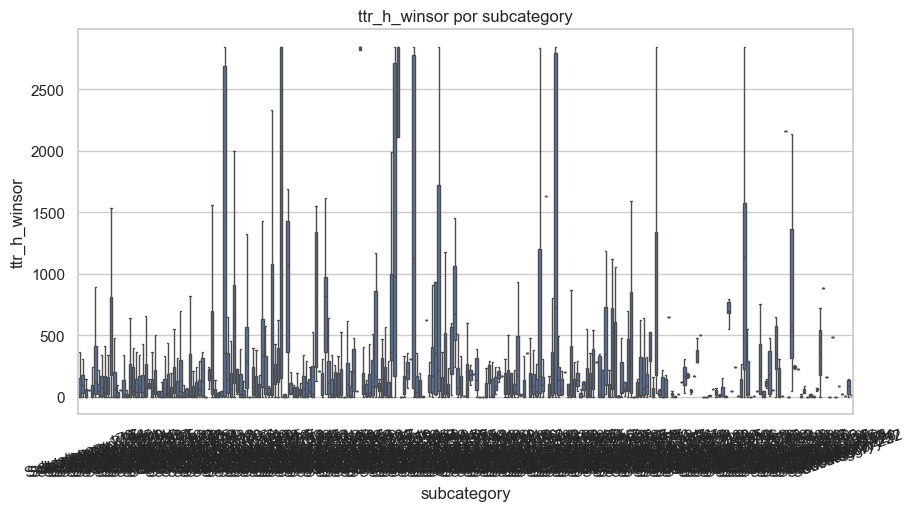

In [23]:
print_section("9.2) Boxplots por niveles/categorías")

def safe_boxplot(df_, value, by):
    if by in df_.columns and value in df_.columns:
        tmp = df_[[value, by]].dropna()
        if not tmp.empty:
            ax = sns.boxplot(data=tmp, x=by, y=value, showfliers=False)
            ax.set_title(f"{value} por {by}")
            plt.xticks(rotation=20)
            plt.show()

for by in ["priority_level","impact_level","urgency_level","contact_type","category","subcategory"]:
    if by in df_inc.columns:
        safe_boxplot(df_inc, "ttr_h_winsor", by)


Violinplot


9.3) Violinplot por priority_level


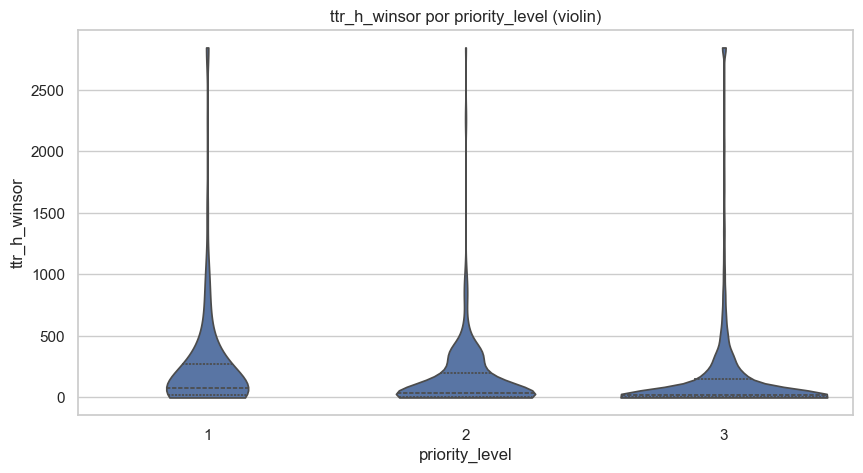

In [24]:
print_section("9.3) Violinplot por priority_level")

if "priority_level" in df_inc.columns:
    tmp = df_inc[["ttr_h_winsor","priority_level"]].dropna()
    if not tmp.empty:
        ax = sns.violinplot(data=tmp, x="priority_level", y="ttr_h_winsor", cut=0, inner="quartile")
        ax.set_title("ttr_h_winsor por priority_level (violin)")
        plt.show()


Scatter simple (muestra)


9.4) Scatter ttr_h vs tiempo de apertura (muestra)


/var/folders/33/290p5x_x4c58chl0x90_f8yh0000gn/T/ipykernel_7537/1573859298.py:8: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_seconds = (tmp["opened_at"].view("int64") // 10**9)


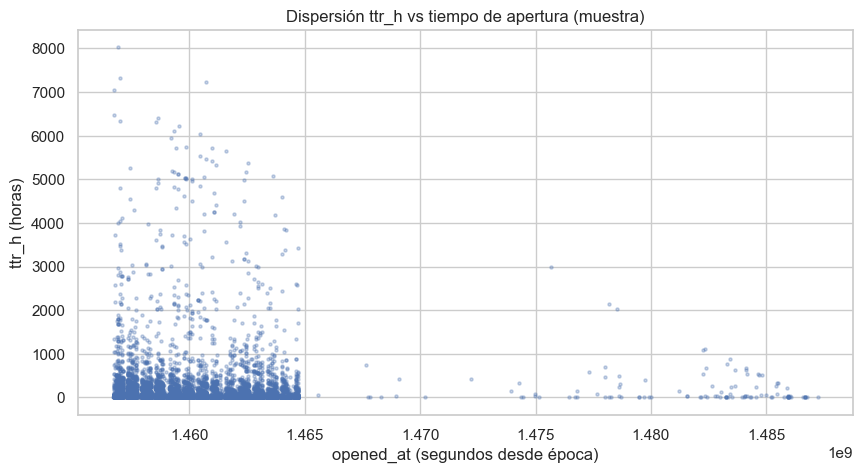

In [25]:
print_section("9.4) Scatter ttr_h vs tiempo de apertura (muestra)")

if "opened_at" in df_inc.columns and "ttr_h" in df_inc.columns:
    tmp = df_inc[["opened_at","ttr_h"]].dropna().copy()
    if len(tmp) > 10000:
        tmp = tmp.sample(10000, random_state=SEED)
    # convertir datetime a número (ns→s)
    x_seconds = (tmp["opened_at"].view("int64") // 10**9)
    fig, ax = plt.subplots()
    ax.scatter(x_seconds, tmp["ttr_h"], s=5, alpha=0.3)
    ax.set_xlabel("opened_at (segundos desde época)")
    ax.set_ylabel("ttr_h (horas)")
    ax.set_title("Dispersión ttr_h vs tiempo de apertura (muestra)")
    plt.show()


Heatmap día–hora de apertura


9.5) Heatmap día–hora de apertura


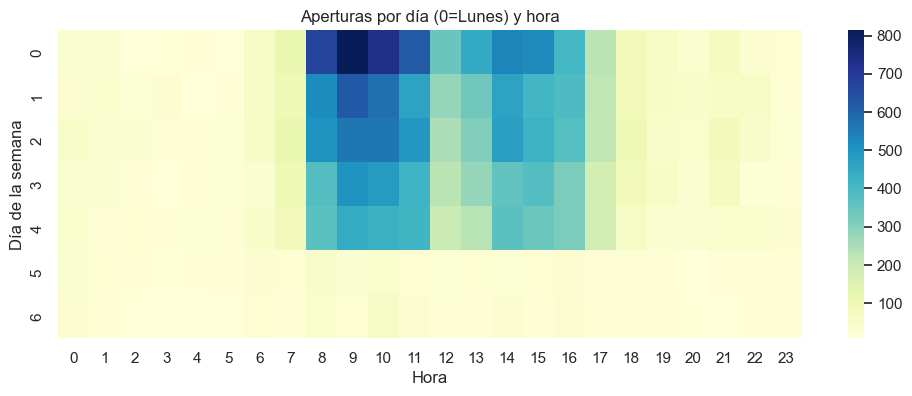

In [26]:
print_section("9.5) Heatmap día–hora de apertura")

if "opened_at" in df_inc.columns:
    df_inc["dow"] = df_inc["opened_at"].dt.dayofweek  # 0=Lunes
    df_inc["hour"] = df_inc["opened_at"].dt.hour
    heat = df_inc.groupby(["dow","hour"]).size().unstack(fill_value=0)
    plt.figure(figsize=(12,4))
    sns.heatmap(heat, cmap="YlGnBu")
    plt.title("Aperturas por día (0=Lunes) y hora")
    plt.xlabel("Hora")
    plt.ylabel("Día de la semana")
    plt.show()


Tendencia mensual


9.6) Tendencia mensual de aperturas


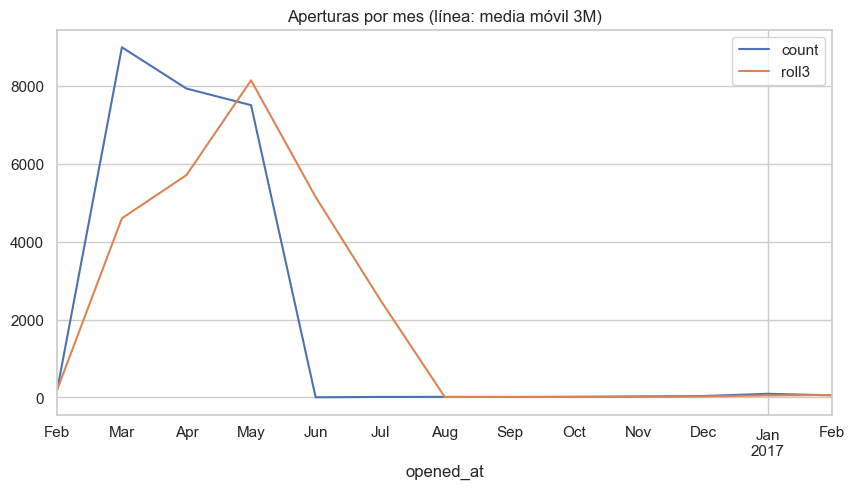

In [27]:
print_section("9.6) Tendencia mensual de aperturas")

if "opened_at" in df_inc.columns:
    monthly = df_inc.set_index("opened_at").resample("MS").size().rename("count").to_frame()
    monthly["roll3"] = monthly["count"].rolling(3, min_periods=1).mean()
    monthly.plot(title="Aperturas por mes (línea: media móvil 3M)")
    plt.show()


Features sin fuga y exportación para modelar

In [28]:
print_section("10) Selección de features sin fuga + exportación CSV")

candidate_features = [
    "opened_at",
    "contact_type",
    "category",
    "subcategory",
    "impact_level",
    "urgency_level",
    "priority_level",
    # "assignment_group",  # incluir solo si es conocido al abrir en tu proceso
]

existing_feats = [c for c in candidate_features if c in df_inc.columns]
missing_feats = [c for c in candidate_features if c not in df_inc.columns]
print("Features presentes:", existing_feats)
if missing_feats:
    print("ATENCIÓN - No existen estas propuestas:", missing_feats)

# Variables a exportar
cols_to_export = ["number","ttr_h","ttr_outlier","ttr_h_log","ttr_h_winsor"] + existing_feats
cols_to_export = [c for c in cols_to_export if c in df_inc.columns]

df_model = df_inc[cols_to_export].copy()

# Orden sugerido
ordered = ["number","ttr_h","ttr_outlier","ttr_h_log","ttr_h_winsor"] + existing_feats
ordered = [c for c in ordered if c in df_model.columns]
df_model = df_model[ordered]

print("Shape dataset modelado:", df_model.shape)
display(df_model.head(3))

EXPORT_PATH = "incidents_clean_for_model.csv"  # cambia a tu carpeta T3 si lo deseas
df_model.to_csv(EXPORT_PATH, index=False, encoding="utf-8")
print(f"Archivo exportado: {EXPORT_PATH}  |  Tamaño: {os.path.getsize(EXPORT_PATH)/1024:.1f} KB")



10) Selección de features sin fuga + exportación CSV
Features presentes: ['opened_at', 'contact_type', 'category', 'subcategory', 'impact_level', 'urgency_level', 'priority_level']
Shape dataset modelado: (24918, 12)


,number,ttr_h,ttr_outlier,ttr_h_log,ttr_h_winsor,opened_at,contact_type,category,subcategory,impact_level,urgency_level,priority_level
3,INC0000045,10.216667,0,2.417401,10.216667,2016-02-29 01:16:00+00:00,Phone,Category 55,Subcategory 170,2,2,3
12,INC0000047,29.200000,0,3.407842,29.200000,2016-02-29 04:40:00+00:00,Phone,Category 40,Subcategory 215,2,2,3
19,INC0000057,20.750000,0,3.079614,20.750000,2016-02-29 06:10:00+00:00,Phone,Category 20,Subcategory 125,2,2,3


Archivo exportado: incidents_clean_for_model.csv  |  Tamaño: 3011.3 KB
